Hello,

I am still on my debuts on Kaggle and I will try to show a technique that could be used in estimating how much unpredictibality is contained in a stationnary time serie signal in terms of variance. One of the usage of the technique would be to use it to estimate how much varaince our model is suppose to predict from a time series and we can extend that to measure how much our model is overfitting/underfitting when it comes to variance

I will do the demonstration with a stationary sequence that is generated with an autoregressive model. That sequence will be affected by white noise that could be considered as a measurement noise for example. So the basic idea is to be able to figure out how much variance is coming from the white noise (unpredictable) and the variance coming from the autoregressive model. Once this is done, we will get the autocorrelation vector of the signal generated with the autoregressive model.

Let's assume that the sampling frequency is good to capture the high and low frequencies contained in the signal.

In [1]:
import numpy as np 
from statsmodels.graphics.tsaplots import plot_acf
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

We will start by generating two independant random white noises "e" and "v". 

In [2]:
N = 100000 # Sample size
fsampling = 1 # sampling frequency
# Generating the first random sequence
np.random.seed(1)
e = 2*np.random.randn(N)
# Choosing another seed to generate another random sequence
np.random.seed(2)
v = np.random.randn(N)
# Calculating the covariance matrix of e and v to make sure
# that there is no correlation between those two signals.
print('Covariance matrix of e and v:')
np.cov(np.array([e,v]))

Covariance matrix of e and v:


array([[ 3.98668522e+00, -1.45286834e-03],
       [-1.45286834e-03,  1.00408719e+00]])

The elements off-diagonal of the covariance matrice are negligeable so we can consider that there is no correlation between "e" and "v". We made sure of that by choosing different seeds when we wanted to generate "e" and "v".

One way to verify that  "e" and "v" are white noises is to see their autocorrelation coefficients. By definition, there is no correlation in time between each sample in a sationnary white noise. The confidence interval is 95%.

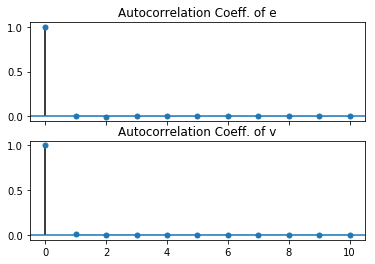

In [3]:
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
plot_acf(e, ax=ax1, lags=10, alpha=0.05,title='Autocorrelation Coeff. of e');
plot_acf(v, ax=ax2, lags=10, alpha=0.05,title='Autocorrelation Coeff. of v');
plt.show()

The two autocorrelation graphs show a typical behavior of a stationnary white noise. It is showing that we cannot use the value at lag 0 (that could be interpreted as the value that we have now) to predict the values for the next sampling periods.

Another way to achieve the same conclusion is to use the power spectral density (PSD) of those signals. I will use just the signal "e" here but keep in mind that the same logic applies to v (since it is a stationnary white noise). 

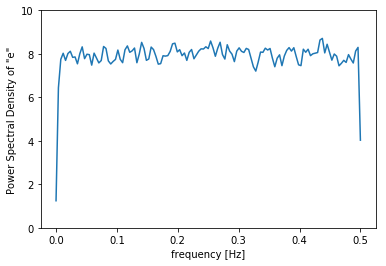

In [4]:
# Calculate the power spectral density of "e"
f, PSDe = scipy.signal.welch(e, fs=fsampling, window='hanning', nperseg=256, 
                               noverlap=None, nfft=None, detrend='constant', 
                               return_onesided=True, scaling='density', axis=-1);

#Plotting the PSD of "e"
plt.plot(f, PSDe)
plt.ylim([0.5e-3, 10])
plt.xlabel('frequency [Hz]')
plt.ylabel('Power Spectral Density of "e"')
plt.show()

The PSD of "e" is pretty much equally distributed through all the frequencies. So, we cannot tell that there a dominant frequency or a range of frequencies. So there is no model that can explain the behavior of that time serie.

Let's add some correlation to signal "e" now. We will put "e" through an autoregressive model of first degree AR(1) which will generate a signal "x"  : 
x(k) = a*x(k-1) + (1-a)*e(k)

a is the parameter that will describe the dynamic of autoregressive model.

We will also see the autocorrelation coefficients graph of "x". 

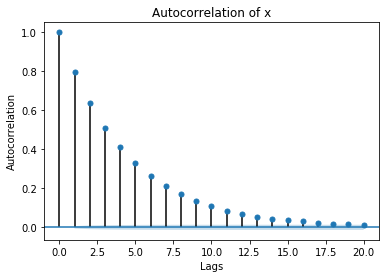

In [5]:
# Generate a vector x having the same length as the signals e.
x = np.zeros(N,)

# Generate the values of x based on the AR(1) recurrent equation.
a = 0.8 # Parameter of the autoregressive model
for t in range(N):
    x[t] = a*x[t-1] + (1-a)*e[t] 

# Autocorrelation of x.    
plot_acf(x, lags=20, alpha=0.05,title='Autocorrelation of x');
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

As you can see, the time serie "x" is having correlation in time between its samples. This means that we can use the value of lag 0 to predict the values for the next samples. In this specific case and since the model used is AR(1), an easy way to predict model's dynamic (parameter "a") here is to take the value of the autocorrelation coefficient at lag=1 and it will be equal to the parameter "a" (see "Time Series Analysis-Forecasting and Control" for more details).

Now if we take a look at the PSD of x

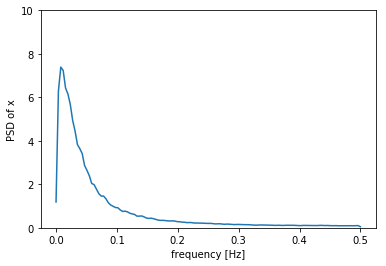

In [6]:
f, PSDx = scipy.signal.welch(x, fs=fsampling, window='hanning', nperseg=256, 
                               noverlap=None, nfft=None, detrend='constant', 
                               return_onesided=True, scaling='density', axis=-1);
plt.plot(f, PSDx)
plt.ylim([0.5e-3, 10])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD of x')
plt.show()

Now let's assume that the signal "x" is a measurment of a particular variable that we measure. Usually, each measurement is contaminated but a white noise that comes from different unexplained sources. 

The signal "y" is the measurement the signal "x", which is the addition of "x" (signal that we want to know) and "v" (white noise that comes from the fact of measuring "x").

Please keep in mind that in simulation, we have the possibility to have access to all the signals. But in real life, we only have acess to "y" and we don't know much about "x" and "v".

Let's see the variances of "x", "v" and "y".

In [7]:
# Generating the time serie "y" that represents the measured value
y = x+v
print("The variance of x is :"+"{:.3}".format(np.var(x)))
print("The variance of x is :"+"{:.3}".format(np.var(v)))
print("The variance of x is :"+"{:.3}".format(np.var(y)))

The variance of x is :0.44
The variance of x is :1.0
The variance of x is :1.45


So we can easily see that the variance of "y" is the sum of the variance of "x" and "v" since those two signals are independant.

Please note that the time serie "x" is very corrupted by "v" 

So now, we need to see how we can estimate the of "x" and the one of "v" simply by having access to "y".

Let's take a look at the autocorrelation coefficients graph for "y".

In [8]:
print("The variance of x is :"+"{:.2%}".format(((np.var(x)/np.var(y)))))
print("The variance of v is :"+"{:.2%}".format(((np.var(v)/np.var(y)))));

The variance of x is :30.42%
The variance of v is :69.45%


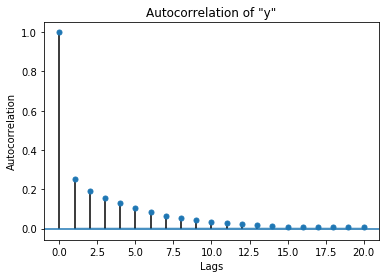

In [9]:
plot_acf(y, lags=20, alpha=0.05,title='Autocorrelation of "y"');
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

So just based on the autocorrelation coefficients of "y" and if we try estimating the parameter "a" for the AR(1) using the same technique as above then we would get around 0.2 for the parameter "a" instead of 0.8 (that is the value used to generate the singal "x" from "e"). So you can see how the measurement noise "v" is affecting "x" and it can be misleading by using just "y" without any form of signal processing.

Now let's take a look at the PSD of "y" and we will put it in the same graph as the one for "v" and "x".

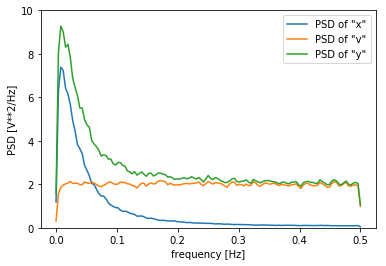

Variance of y using the PSD : 1.415390
Variance of y using the time serie : 1.445659


In [10]:
#PSD of "y"
f, PSDy = scipy.signal.welch(y, fs=fsampling, window='hanning', nperseg=256, 
                               noverlap=None, nfft=None, detrend='constant', 
                               return_onesided=True, scaling='density', axis=-1);
#PSD of "v"
f, PSDv = scipy.signal.welch(v, fs=fsampling, window='hanning', nperseg=256, 
                               noverlap=None, nfft=None, detrend='constant', 
                               return_onesided=True, scaling='density', axis=-1);

plt.plot(f, PSDx)
plt.plot(f, PSDv)
plt.plot(f, PSDy)
plt.ylim([0.5e-3, 10])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend(('PSD of "x"','PSD of "v"','PSD of "y"'))
plt.show()

print('Variance of y using the PSD : %f' % np.trapz(PSDy, x=f, dx=0.01, axis=-1))
print('Variance of y using the time serie : %f' %np.var(y))

The PSD of "y" is equal to the sum of the PSDs of "x" and "v" ("x" and "v" are independant). In the frequency range between 0.4Hz and 0.5Hz, we can see that the PSDs of "y" and "v" are equal since the one of "x" is almost nul. 


As i stated earlier, we only have access to "y" in the real world so we need to estimate the PSD of "x" using just the PSD of "y" and we will use the fact that we have access to "x" to verify the method. 

So for that, we can take the mean value of the PSD of "y" in the frequency range between 0.4Hz and 0.5Hz. Then, we can substratct that value from the PSD of "y" and it will give an estimate of the PSD of "x".



In [11]:
#Extract the frequency range between 0.4Hz and 0.5Hz
condition = np.greater(f, 0.4)
index = np.extract(condition,f)

# Get the PSD of "y" between the range of 0.4Hz and 0.5Hz
PSDy_par = np.zeros(index.shape[0],)
j = 0
for i in range(f.shape[0]-1) :
    if f[i] >= 0.4 :
        PSDy_par[j] = PSDy[i]
        j = j+1
      
est_var_v = 5*np.trapz(PSDy_par, x=index, dx=0.01, axis=-1)
    
print("Estimation of the white noise v variance : %f" % est_var_v)
print("Variance of the white noise v using the PSD : %f" % np.trapz(PSDv, x=f, dx=0.01, axis=-1))
print("Variance of the white noise v using the time serie: %f" % np.var(v))

Estimation of the white noise v variance : 0.992209
Variance of the white noise v using the PSD : 0.996698
Variance of the white noise v using the time serie: 1.004077


So as you can see, we were able to have a very good estimate of the variance of the white noise by just using the PSD of "y". Now let's try to estimate the PSD of "x". We will substract the estimated variance of "v" from the PSD of "y" and we will compare the result to the actual PSD of "x".

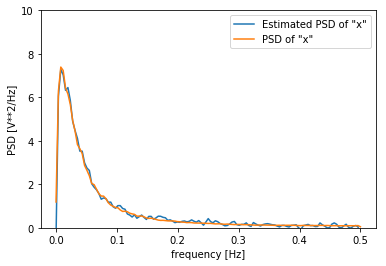

Variance of "x" using the PSD : 0.423181
Variance of "x" using the PSD : 0.420594


In [12]:
# Estimation of the PSD of x using only the PSD of y
PSDxhat = PSDy - (5*np.trapz(PSDy_par, x=index, dx=0.01, axis=-1) / (fsampling/2 - 0))

plt.plot(f, PSDxhat)
plt.plot(f, PSDx)
plt.ylim([0.5e-3, 10])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend(('Estimated PSD of "x"','PSD of "x"'))
plt.show()

print('Variance of "x" using the PSD : %f' % np.trapz(PSDxhat, x=f, dx=0.01, axis=-1))
print('Variance of "x" using the PSD : %f' % np.trapz(PSDx, x=f, dx=0.01, axis=-1))

So we were able to filter out the PSD of "v" out of the PSD of "y" which resulted in the PSD of "x". As you can see on the graph above, the estimate is pretty much accurate and the estimated variance of "x" is accurate too.

Now if we have a model (neural network for example) that we will use to estimate the "y" (assume that "y" is the training time series for that model) then in terms of variance that model should not predict the variations caused by the sequence "v" since they are unpredictable (generated from a white noise).

Since we have an estimated PSD for "x" then we can push it a bit further for that case and use it to estimate the parameter of the AR(1) used to generate "x". Using the Inverse Fourier Transform, we get the autocorrelation coefficients of "x". 


In [13]:
Rxhat = abs(np.fft.ifft(PSDxhat, n=None, axis=-1, norm=None))
Rx = abs(np.fft.ifft(PSDx, n=None, axis=-1, norm=None))
Ry = abs(np.fft.ifft(PSDy, n=None, axis=-1, norm=None))

Rxhat = Rxhat / Rxhat[0]
Rx = Rx / Rx[0]
Ry = Ry / Ry[0]

print("The real value of parameter a: 0.8")
print("The parameter a using the estimate PSD of x: %f" %Rxhat[1])
print("The parameter a using the PSD of x: %f" %Rx[1])
print("The parameter a using the PSD of y: %f" %Ry[1])

The real value of parameter a: 0.8
The parameter a using the estimate PSD of x: 0.703880
The parameter a using the PSD of x: 0.725567
The parameter a using the PSD of y: 0.208393


Conclusion :

In this Kernel, I tried to show a technique that is based on the stationarities of the signals to evaluate how unpredictibality is contained in a signal using PSD analysis. Using that technique, the variance of the white noise was estimated accurately using just the signal in hand ("y"). The signals "x" and "v" were used to verify the accuracy of the method. From that estimation, the autoregressive model was estimated with more precision.

I hope that you will find this kernel interesting and useful in your analysis. Feel free if you are interested in a collboration using that method or any other type of collaborations.